In [1]:
import pandas as pd
import math
import re, os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Process LIBER data sets. This datasets has 4 phenotypes: control, Biopolar, MDD(major depressive disorder), schizophrenia. There are mainly two races: caucasian and afrian america. Michael Nagle has done quantification for these samples. The procedure is as follows: 1. align reads to the genome. 2. count the reads. 3. transfer the count to tpm.
The procedure for this code is to use the tpm expression matrix as input, then combine it with the clinical information to plot the expression level for those genes we are interested that could be potential targets for repeat expansion.

In [2]:
# 1. get gene id and name mapping for human and build id to name dictionary
fn = '/home/lis262/Downloads/human_v30.gff'
map_fn = '/home/lis262/Downloads/human_gene_id_name_map.txt'

In [3]:
def get_human_gene_id_name_map(gff, id_fn):
    '''this function parse the gff file and create a {genename: geneid} dictionary
    * gff: input file
    * id_fn: id mapping file. has 2 columns. '''
    if not os.path.exists(id_fn):
        id_df = pd.read_csv(fn, sep='\t',comment='#',header=None)
        id_df = id_df[id_df[2].values=='gene']
        id_df = id_df.reset_index(drop=True)
        id_df['id'] = id_df[8].map(lambda x: re.search('(?<=ID=).+?(?=\.)', x).group(0))
        id_df['name'] = id_df[8].map(lambda x: re.search('(?<=gene_name=).+?(?=;)', x).group(0))
        id_df[['id','name']].to_csv(map_fn, sep='\t', index=False)
    else:
        id_df = pd.read_csv(id_fn, sep='\t',header=0)

    id2name_dic = id_df.set_index('id')['name'].to_dict()
    return id2name_dic

In [4]:
id2name_dic = get_human_gene_id_name_map(fn, map_fn)

Here we define interested genes in the slides.

In [5]:
# define interested genes
interest_genes = ['Cdk9', 'Cdk12', 'Supt4h1', 'Supt5h', 'Elof1', 'Tcea2', 'Brca1', 
                  'Bard1', 'EloA', 'parp1', 'Supt16H', 'Ercc6', 'Ercc5', 'Crebbp', 
                  'Ep300', 'Hmgb1', 'Smarcad1', 'Setx', 'Dhx9']
interest_genes = [g.upper() for g in interest_genes]

In [6]:
def show_interested_genes_tpm(tpm_fn, clinical_fn, genes, id2name_dic, race):
    '''this function shows the tpm of interested genes
    * genes: a list of gene names
    * id2name_dic: dictionary of {geneid: genename}
    '''
    meta_df = pd.read_csv(clinical_fn, sep='\t')
    meta_df['BrNum'] = meta_df['BrNum'].map(lambda x: 'Br' + str(x))
    #-------- original # of samples
    # meta_df['Race'].value_counts()
    #-------- extract expression of interested genes, replace geneid with gene name
    tpm_df = pd.read_csv(tpm_fn, sep='\t',header=0,index_col=0,low_memory=False)
    # add gene gene
    tpm_df['name'] = tpm_df.index.map(lambda x: id2name_dic[x].upper() if x in id2name_dic else x)
    int_tpm_df = tpm_df[tpm_df['name'].isin(genes)]
    int_tpm_df.index = int_tpm_df['name']
    del int_tpm_df['name']
    #------- extract interested samples' clinical information
    int_samples = int_tpm_df.columns.tolist()
    int_meta_df = meta_df.query('Race == @race and BrNum in @int_samples')
    int_meta_df = int_meta_df.reset_index(drop=True)
    int_sample_dic = {k:list(v) for k,v in int_meta_df.groupby('DxGroup')['BrNum']} # {phenotype:[samples]}
    # build dataframe, the first column is samples id, the 2nd is phenotyp, the others are genes.
    # values are tpm for each gene
    g_df = int_meta_df[['BrNum','DxGroup']]
    g_df = g_df.reset_index(drop=True)
    for g in genes:
        brnum_tpm_dic = int_tpm_df.loc[g,:].to_dict()
        g_df[g] = g_df['BrNum'].map(lambda x: brnum_tpm_dic[x] if x in brnum_tpm_dic else None)
    return g_df

In [7]:
cauc_tpm_fn = '/home/lis262/Downloads/TPM_counts_CAUC.tsv'
aa_tpm_fn = '/home/lis262/Downloads/TPM_counts_AA.tsv'
clinical_fn = '/home/lis262/Downloads/LIBD_DemographicClinicalData_746.csv'
cauc_tpm_df = show_interested_genes_tpm(cauc_tpm_fn, clinical_fn, interest_genes, id2name_dic, 'CAUC')
aa_tpm_df = show_interested_genes_tpm(aa_tpm_fn, clinical_fn, interest_genes, id2name_dic, 'AA')
#  merge the tpm of CAUC and AA
int_tpm_df = cauc_tpm_df.append(aa_tpm_df)

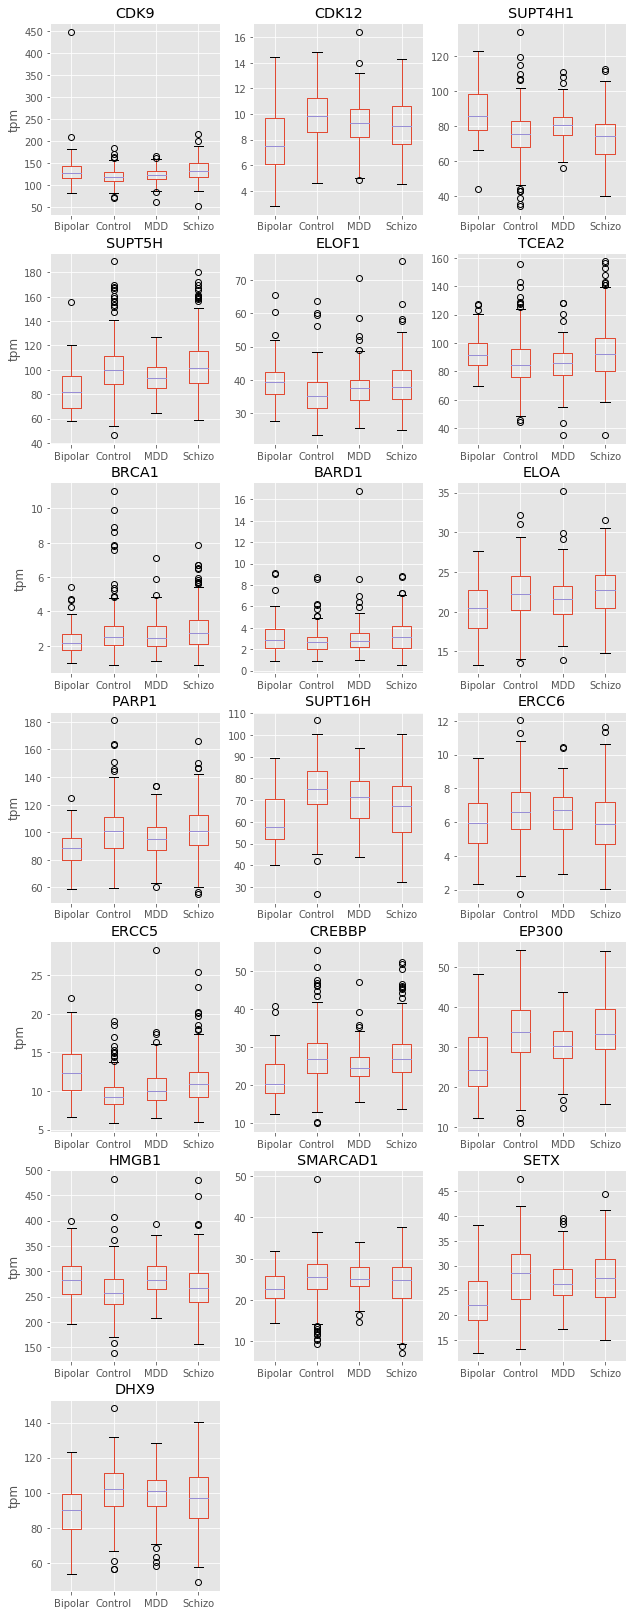

In [14]:
columns = 3
rows = math.ceil(len(interest_genes))
i = 0
# fig = plt.figure()
axes = []
fig = plt.figure(figsize=(10, 80))
for g in interest_genes:
    i += 1
    ax_i = fig.add_subplot(rows, columns, i)
    g_df = int_tpm_df[['DxGroup',g]]
    
    ax = g_df.boxplot(by='DxGroup',grid=True, ax=ax_i)
    figs = ax.get_figure()
    figs.suptitle('')
    ax.set_title(g)
    ax.set_xlabel('')
    if i % 3 == 1:
        ax.set_ylabel('tpm')

In [18]:
# save figure results
# for g in interest_genes:
#     i += 1
#     g_df = int_tpm_df[['DxGroup',g]]
    
#     ax = g_df.boxplot(by='DxGroup',grid=True)
#     figs = ax.get_figure()
#     figs.suptitle('')
#     ax.set_title(g)
#     ax.set_xlabel('')
#     ax.set_ylabel('tpm')
#     plt.savefig('/home/lis262/LIBER/'+ g + '.png')